In [1]:
#####################################
### Import the relevant libraries ###
#####################################

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import psutil
from pathlib import Path
import os
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix

2024-12-08 00:01:57.619374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733616117.629504   42251 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733616117.633352   42251 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 00:01:57.645961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Convert to PNG
#RUN ONCE
PATH = Path("dataset") / "GTSRB" / "Training"



def convert_dataset_to_png():
    for path,_,files in os.walk(PATH):
        for file in files:
            if file.endswith(".ppm"):
                file_path = Path(path) / file
                new_path = Path(path) / (file[:-4] + ".png")
                img = cv2.imread(file_path)
                cv2.imwrite(new_path,img)

#convert_dataset_to_png()

In [3]:
#Memory usage
def log_memory():
    #Log memory usage
    process = psutil.Process()
    print(f"{process.memory_info().rss / 1000 / 1000}mb")  # in mb 
    

def log_gpu_memory():
    print(tf.config.experimental.get_memory_info('GPU:0'))

log_gpu_memory()
log_memory()

{'current': 0, 'peak': 0}
893.5424mb


I0000 00:00:1733616119.235547   42251 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


***
# **DATA**

In [4]:
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [5]:
_N = 64
batch_size = 64

In [6]:
dataset = tf.keras.utils.image_dataset_from_directory(
  PATH,
  label_mode="int",
  seed=42,
  image_size=(_N, _N),
  color_mode="rgb",
  batch_size=batch_size,
  shuffle=True) 
dataset.class_names = LABELS

Found 39209 files belonging to 43 classes.


In [7]:
#Split into test / train sets
log_memory()

#dataset = dataset.shuffle(buffer_size=batch_size,seed=42)
log_memory()
SIZE = len(dataset)

train_dataset = dataset.take(int(0.8 * SIZE))
test_dataset = dataset.skip(int(0.8 * SIZE))

log_memory()

1153.634304mb
1153.634304mb
1153.634304mb


***
# **BASE TRAINING**

In [8]:
epochs = 30
n_classes = len(LABELS)
print(n_classes)

43


In [9]:
########################
### Define the model ###
########################

def get_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(_N,_N,3)))
    model.add(tf.keras.layers.Resizing(_N,_N)) 
    model.add(tf.keras.layers.Rescaling(1.0 / 255.0))
    
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(n_classes))

    

    model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    print(model.summary())

    return model
model = get_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 649,003 (2.48 MB)

 Trainable params: 649,003 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
"""class AdversarialGenerator(tf.keras.utils.PyDataset):
    def __init__(self,model,batch_size,dataset,**kwargs):
        self.batch_size = batch_size #########

        self.dataset = dataset#.batch(batch_size)
        self.iter = dataset.as_numpy_iterator()
        self.model = model
        super().__init__(**kwargs)
    def __len__(self):
        return len(self.dataset) // self.batch_size#####
    def __getitem__(self,idx):
        abc = self.dataset.skip(idx * batch_size).take(1 * batch_size)####
        for x,y in abc:
            return x,y
        
t = AdversarialGenerator(model,1024,train_dataset)"""
123


123

In [11]:
##########################
### Train a base model ###
##########################

history = model.fit(train_dataset, epochs=epochs)
model.save("model.keras")

Epoch 1/30


I0000 00:00:1733616123.751030   42550 service.cc:148] XLA service 0x7fc380005170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733616123.751056   42550 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-12-08 00:02:03.783805: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733616123.877678   42550 cuda_dnn.cc:529] Loaded cuDNN version 90300


 49/490 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.5260 - sparse_categorical_accuracy: 0.1199

I0000 00:00:1733616126.246716   42550 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


490/490 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.9864 - sparse_categorical_accuracy: 0.4828
Epoch 2/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2143 - sparse_categorical_accuracy: 0.9432
Epoch 3/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1000 - sparse_categorical_accuracy: 0.9735
Epoch 4/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0603 - sparse_categorical_accuracy: 0.9843
Epoch 5/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0420 - sparse_categorical_accuracy: 0.9890
Epoch 6/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9915
Epoch 7/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0241 - sparse_categorical_accuracy: 0.9935
Epoch 8/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0308 - sparse_categorical_accuracy: 0.9906
Epoch 9/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0152 - sparse_categorical_accuracy: 0.9956
Epoch 10/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.018

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━

2024-12-08 00:03:08.608661: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


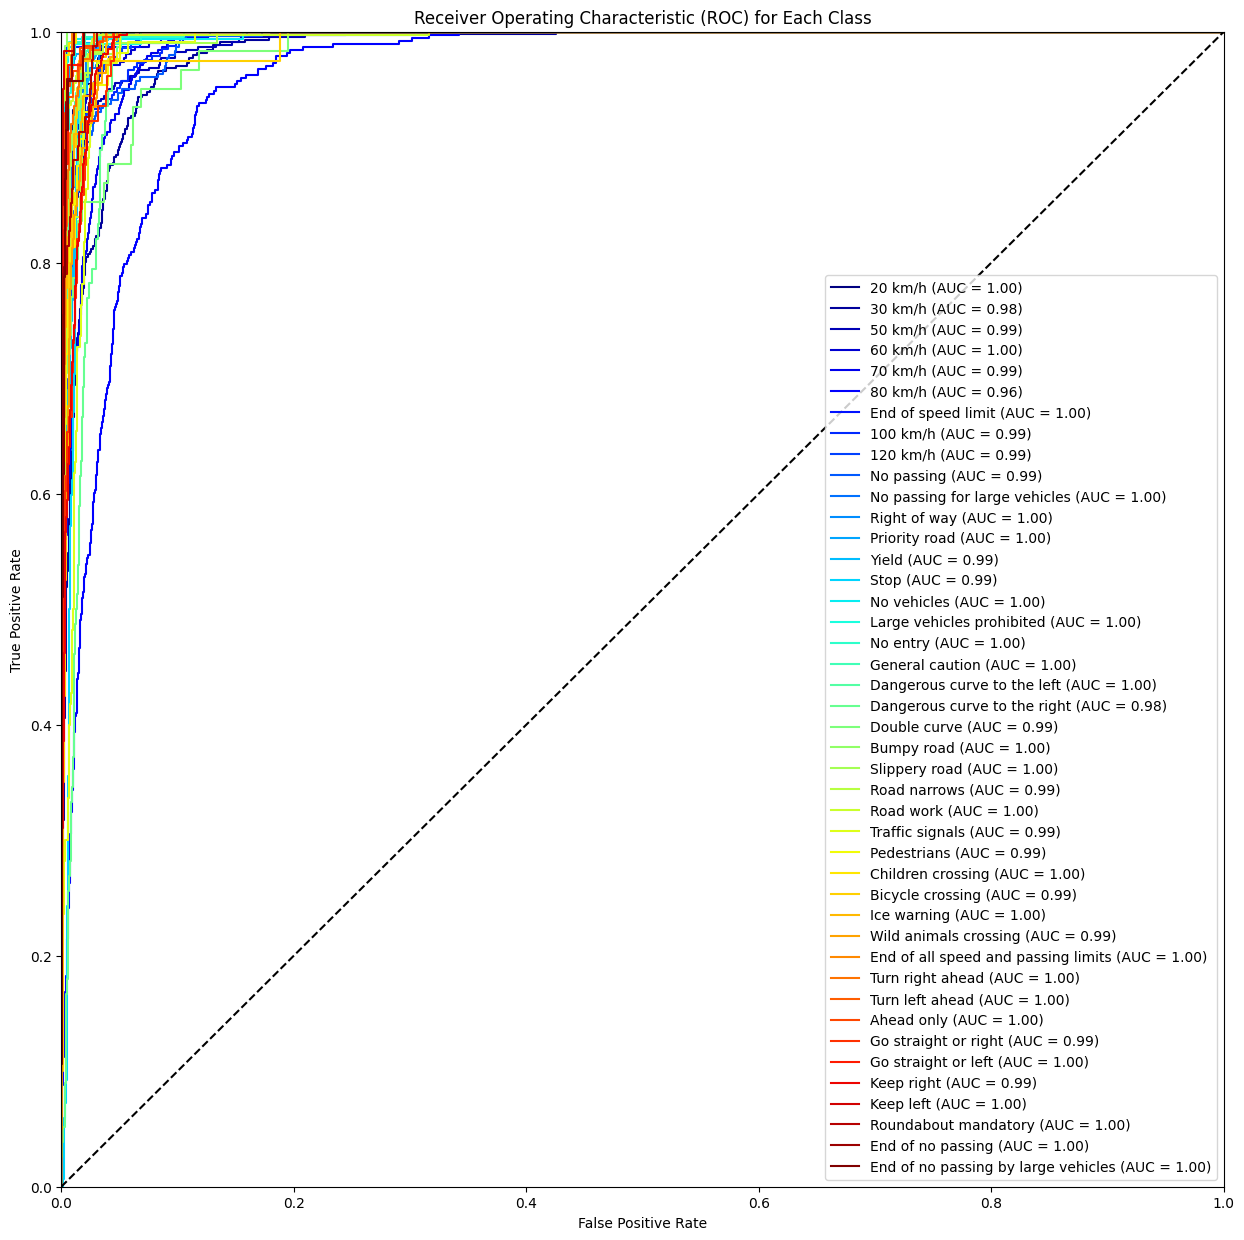

In [12]:
def print_metrics(model,test_dataset):
    y = []
    y_pred_prob = []

    # Iterate through the test dataset
    for images, labels in test_dataset:
        y.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred_prob.extend(predictions)
    y = np.array(y)
    y_pred_prob = np.array(y_pred_prob)
    y_pred_class = np.argmax(y_pred_prob,axis=1)

    precision = precision_score(y, y_pred_class, average='macro')
    recall = recall_score(y, y_pred_class, average='macro')
    f1 = f1_score(y, y_pred_class, average='macro')

    # Display the macro/micro/weighted average metrics
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')

    # Binarize the output (needed for multiclass ROC)
    # This turns the class labels into a one-vs-rest binary format
    y_test_bin = label_binarize(y, classes=np.arange(43))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(43):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(15, 15))
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 43))))
    for i in range(43):
        plt.plot(fpr[i], tpr[i], label=f'{LABELS[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Each Class')
    plt.legend(loc='lower right')
    plt.show()
print_metrics(model,test_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


2024-12-08 00:03:09.373562: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


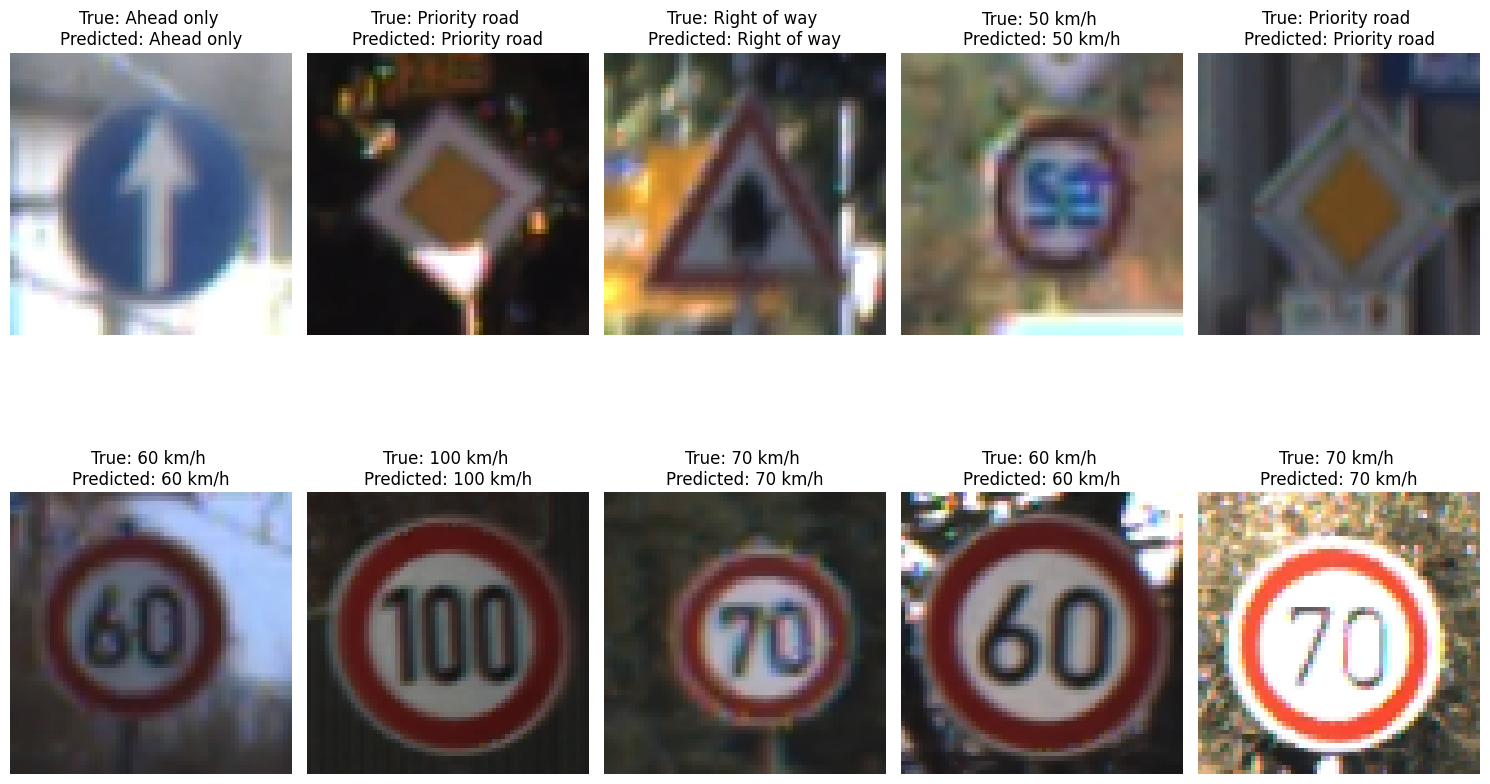

In [13]:
def show_predictions(model,n):
    images = []
    labels = []
    for img,label in dataset.take(n):
        images.extend(img)
        labels.extend(label)
    images = np.array(images)
    labels = np.array(labels)
    predictions = model.predict(images)
    

    predicted_classes = np.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(n):
        true = labels[i]
        pred = predicted_classes[i]
        img = images[i]
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.astype("uint8"))
        plt.title(f"True: {LABELS[true]} \nPredicted: {LABELS[pred]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_predictions(model,10)

613/613 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


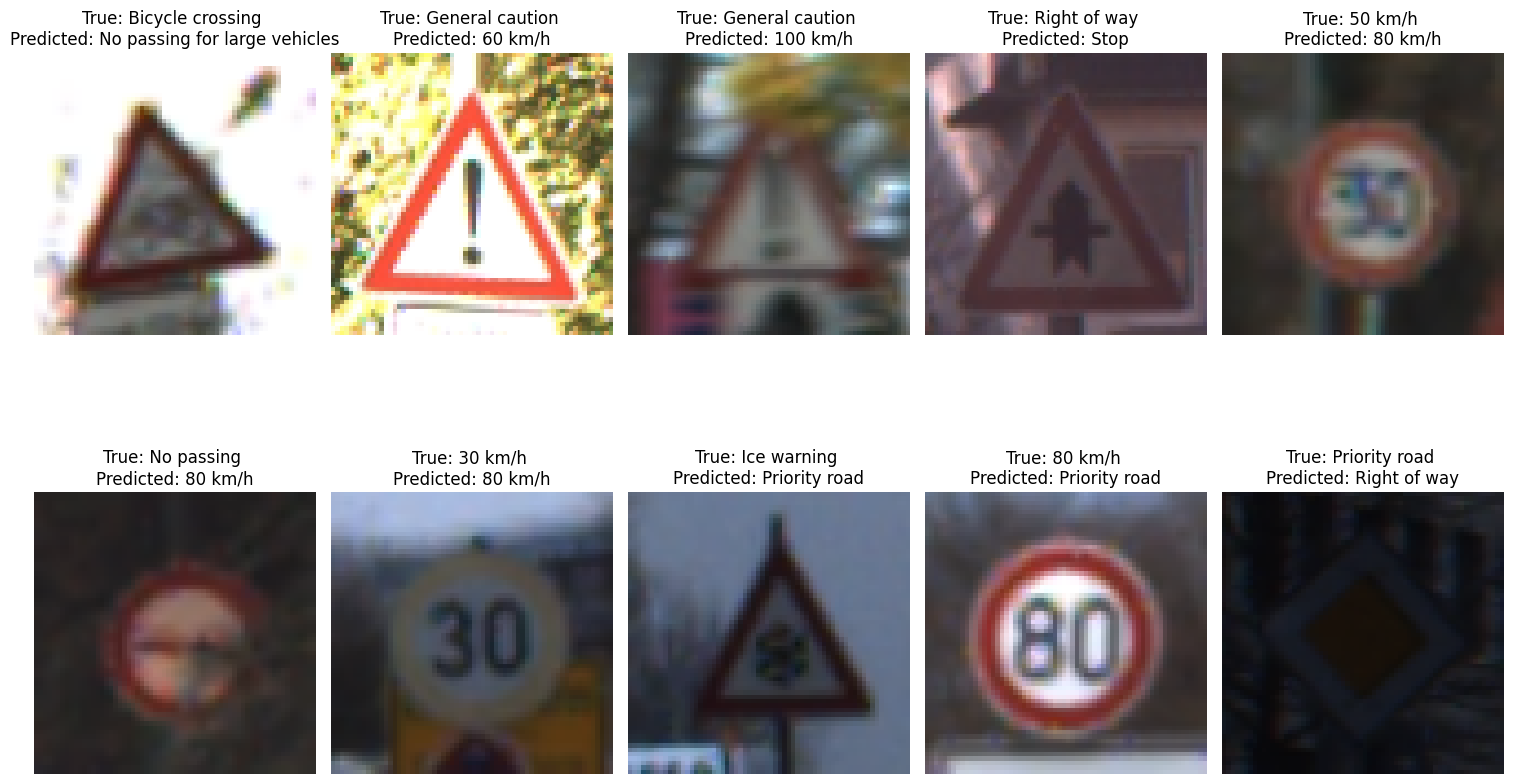

In [14]:
def show_bad_scores(model,n):
    images = []
    labels = []
    y = np.concatenate([y for _, y in dataset], axis=0)
    y_pred = np.argmax(model.predict(dataset), axis=1)
    misclassified = y != y_pred

    for i,(img,label) in enumerate(dataset):
        if misclassified[i]:
            images.extend(img)
            labels.extend(label)
            if len(images) > n:
                break
    images = np.array(images)
    labels = np.array(labels)
    

    

    plt.figure(figsize=(15, 10))
    for i in range(n):
        true = labels[i]
        pred = y_pred[i]
        img = images[i]
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.astype("uint8"))
        plt.title(f"True: {LABELS[true]} \nPredicted: {LABELS[pred]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
show_bad_scores(model,10)

In [15]:
######################################
### Define the PGD attack function ###
######################################

epsilon = 0.3
alpha = 0.1
num_iter = 10
def pgd_attack(model, x, y,epsilon,alpha,num_iter):
    """Perform PGD attack on a batch of images.
    
    Args:
        model: Trained Keras model.
        x: Input images (batch).
        y: True labels (batch).
        epsilon: Maximum perturbation.
        alpha: Step size for each iteration.
        num_iter: Number of PGD iterations.

    Returns:
        Adversarial examples.
    """
    # Make a copy of the input to avoid modifying the original data
    x_adv = tf.identity(x)

    # Iterate PGD for num_iter steps
    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)  # Watch x_adv for gradient computation
            predictions = model(x_adv)  # Forward pass
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)  # Loss w.r.t. true label

        # Compute the gradients of the loss w.r.t. the input
        gradients = tape.gradient(loss, x_adv)
        
        # Perform gradient ascent step in the direction that maximizes the loss
        perturbations = tf.sign(gradients)  # Use the sign of the gradients (FGSM-like step)
        x_adv = x_adv + alpha * perturbations  # Update the adversarial example
        
        # Project the adversarial example to ensure it's within epsilon-ball of the original image
        x_adv = tf.clip_by_value(x_adv, x - epsilon, x + epsilon)
        
        # Ensure the adversarial examples are within the valid input range [0, 255]
        x_adv = tf.clip_by_value(x_adv, 0, 255)
    
    return x_adv

In [18]:
print(len(dataset))

613


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


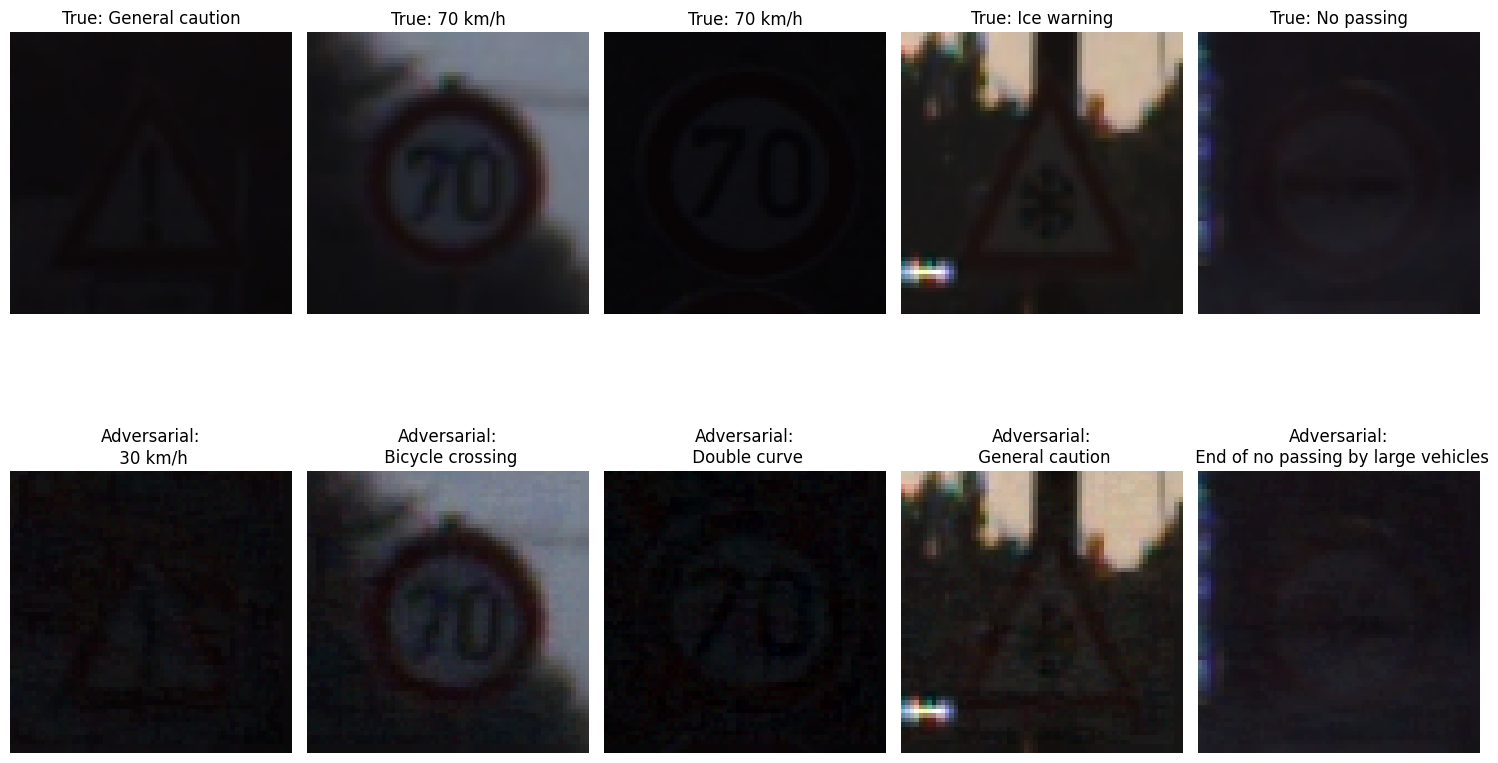

Accuracy on adversarial examples: 0.9531


In [ ]:
############################################################################
### Define the function to visualize the original and adversarial images ###
############################################################################

def original_vs_adversarial_images(model):
    
    x_og = []
    y_og = []
    for img,label in dataset.take(2):
        x_og.extend(img)
        y_og.extend(label)

    x_og = np.array(x_og)
    y_og = np.array(y_og)
    y_pred_og = np.argmax(model.predict(x_og),axis=1)
    x_adv = pgd_attack(model,x_og,y_og,epsilon,alpha,num_iter)
    y_pred = np.argmax(model.predict(x_adv),axis=1)

    plt.figure(figsize=(15, 10))
    display_count = 0
    for i in range(len(x_og)):
        # Check if the class changes after the attack
        
        if y_og[i] != y_pred[i]:
            original_image = x_og[i].reshape(_N, _N,3).astype(np.uint8)
            
            adversarial_image = x_adv[i].numpy().reshape(_N, _N,3).astype(np.uint8)

            # Plot original images
            plt.subplot(2, 5, display_count + 1)
            plt.imshow(original_image)
            plt.axis('off')
            plt.title(f'True: {LABELS[y_og[i]]}')

            # Plot adversarial images
            plt.subplot(2, 5, display_count + 6)
            plt.imshow(adversarial_image)
            plt.axis('off')
            plt.title(f'Adversarial:\n {LABELS[y_pred[i]]}')

            # Increment the display counter
            display_count += 1
            
            # Stop after displaying 10 images
            if display_count == 5:
                break
    print(i)
    plt.tight_layout()
    plt.show()
    accuracy_adv = np.mean(y_pred == y_og)

    print(f'Accuracy on adversarial examples: {accuracy_adv:.4f}')

epsilon = 5
alpha = 2
num_iter = 10

original_vs_adversarial_images(model)

***
# **ADVERSARIAL TRAINING**

In [21]:
################################################
### Define the adversarial training function ###
################################################

def adversarial_training(model, train_dataset, optimizer, loss_fn, epsilon, alpha, num_iter, epochs):
    """
    Performs adversarial training with PGD adversarial examples.
    
    Args:
    model: The model to train.
    train_dataset: A TensorFlow dataset for training.
    optimizer: The optimizer for model training.
    loss_fn: Loss function to use.
    epsilon: Maximum perturbation for PGD (epsilon).
    alpha: Step size for PGD.
    num_iter: Number of PGD iterations for generating adversarial examples.
    epochs: Number of training epochs.
    
    Returns:
    model: The trained model.
    """
    for epoch in range(epochs):
        start_time = time.time()  # Record start time for the epoch
        print(f"Epoch {epoch + 1}/{epochs}")

        # Accuracy metric for the epoch
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        
        # Training loop over batches
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # Generate adversarial examples using PGD
                x_adv_batch = pgd_attack(model, x_batch, y_batch, epsilon=epsilon, alpha=alpha, num_iter=num_iter)
                
                # Combine original and adversarial examples for training
                combined_x = tf.concat([x_batch, x_adv_batch], axis=0)
                combined_y = tf.concat([y_batch, y_batch], axis=0)
                
                # Forward pass
                logits = model(combined_x, training=True)
                
                # Compute the loss
                loss = loss_fn(combined_y, logits)
            
            # Backpropagation
            
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update training accuracy metric
            train_acc_metric.update_state(combined_y, logits)

        # End of epoch: calculate and print accuracy and epoch time
        train_acc = train_acc_metric.result().numpy()
        print("AAA")
        # Evaluate on test dataset (for validation accuracy)
        test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        for x_test_batch, y_test_batch in test_dataset:
            test_logits = model(x_test_batch, training=False)
            test_acc_metric.update_state(y_test_batch, test_logits)
        test_acc = test_acc_metric.result().numpy()

        print(f"Train loss: {loss.numpy():.4f} -|- Train acc: {train_acc:.4f} -|- Test acc: {test_acc:.4f} -|- Time: {(time.time() - start_time):.2f}s")
    
    return model

In [ ]:
##################################
### Train an adversarial model ###
##################################

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_adv = get_model()
model_adv = adversarial_training(model_adv, train_dataset, optimizer, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=num_iter, epochs=epochs)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 649,003 (2.48 MB)

 Trainable params: 649,003 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30


In [ ]:
#####################################################
### Calculate precision, recall, F1 and ROC curve ###
#####################################################

print_metrics(model_adv, X_test, y_test, n_classes)

In [ ]:
####################################################################################
### Attack the model using PGD and visualize the original and adversarial images ###
####################################################################################

# Test the PGD attack
x_test_sample_ADV = X_test
y_test_sample_ADV = y_test

# Generate adversarial examples
x_test_adv_ADV = pgd_attack(model_adv, x_test_sample_ADV, y_test_sample_ADV, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv_ADV = np.argmax(model_adv.predict(x_test_adv_ADV), axis=1)
accuracy_adv_ADV = np.mean(y_pred_adv_ADV == y_test_sample_ADV)

print(f'Accuracy on adversarial examples: {accuracy_adv_ADV:.4f}')
original_vs_adversarial_images(x_test_sample_ADV, y_test_sample_ADV, x_test_adv_ADV, y_pred_adv_ADV)